In [142]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')
sys.path.append('../third_party')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import numpy as np   
import pandas as pd
import pdb
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
from tqdm import tqdm
from time import time

In [144]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *  
from wsc import *

# load third_party functions 
from noisy_CI import *

from gcimpute.gaussian_copula import GaussianCopula
from gcimpute.low_rank_gaussian_copula import LowRankGaussianCopula

In [169]:
def gen_P(d1, d2, het, pr):
    # missingness pattern
    if het=='rank1':
        # rank-1 structure
        lo_p = 0.3
        up_p = 0.9
        u = np.random.uniform(lo_p,up_p,d1).reshape((d1,1))
        v = np.random.uniform(lo_p,up_p,d2).reshape((d2,1))
        P = u @ v.T
    elif het == 'logis1':
        L = 0.5
        k_p = 5
        u = L*np.random.uniform(0,2,d1*k_p).reshape((d1,k_p))
        v = L*np.random.uniform(-1,1,d2*k_p).reshape((d2,k_p))
        AA = u @ v.T
        P = 1/(1+np.exp(-AA))
    elif het == 'logis2':
        L = 0.5
        k_l = 1
        u = L*np.random.uniform(0,2,d1*k_l).reshape((d1,k_l))
        v = L*np.random.uniform(-1,1,d2*k_l).reshape((d2,k_l))
        AA = u@v.T
        P = 1/(1+np.exp(-AA))
    elif het == 'homo':
        P = pr * np.ones((d1,d2))
    return P

In [281]:
def get_weights(p, calib_mask, test_mask):
    calib_idxs = np.where(calib_mask.flatten(order='C')== 1)[0]
    test_idxs = np.where(test_mask.flatten(order='C')== 1)[0]
    n_test = len(test_idxs)
    
    p = p.flatten(order='C')
    odd_ratio = (1-p)/p
    
    weights = np.tile(odd_ratio[calib_idxs], (n_test, 1))
    weights = np.concatenate([weights, odd_ratio[test_idxs].reshape(n_test,1)], axis=1)
    weights /= np.sum(weights,axis=1).reshape((n_test,1))
    
    return weights

def get_ci(M, Mhat, p, calib_mask, test_mask,alpha, allow_inf=True):
    M = M.flatten(order='C')
    Mhat = Mhat.flatten(order='C')
    calib_idxs = np.where(calib_mask.flatten(order='C')== 1)[0]
    test_idxs = np.where(test_mask.flatten(order='C')== 1)[0]
    n_test = len(test_idxs)
    
    scores = np.abs(M - Mhat)
    calib_scores = scores[calib_idxs]
    calib_order = np.argsort(calib_scores)
    st_calib_scores = calib_scores[calib_order] 
    
    p = p.flatten(order='C')
    odd_ratio = (1-p)/p
    
    weight_list = np.tile(odd_ratio[calib_idxs], (n_test, 1))
    weight_list = np.concatenate([weight_list, odd_ratio[test_idxs].reshape(n_test,1)], axis=1)
    weight_list /= np.sum(weight_list,axis=1).reshape((n_test,1))
    weight_list = weight_list[:,:-1]
    
    upper = np.zeros(len(M))    # upper confidence bound
    lower = np.zeros(len(M))    # lower confidence bound
    inf_mask = np.zeros(len(M)) # positions where interval length is infinity
    
    for i in tqdm(range(n_test)):
        weights = weight_list[i]
        cweights = np.cumsum(weights[calib_order])
        est = Mhat[test_idxs[i]]

        if cweights[-1] < 1-alpha:
            inf_mask[test_idxs[i]] = 1
            if allow_inf:
                lower[test_idxs[i]], upper[test_idxs[i]] = -np.inf, np.inf
            else:
                lower[test_idxs[i]] = est - st_calib_scores[-1]
                upper[test_idxs[i]] = est + st_calib_scores[-1]
        else:
            idx = np.argmax(cweights >= 1-alpha)
            lower[test_idxs[i]] = est - st_calib_scores[idx]
            upper[test_idxs[i]] = est + st_calib_scores[idx]
        
    return lower.reshape(test_mask.shape), upper.reshape(test_mask.shape), inf_mask.reshape(test_mask.shape), weight_list
    
def get_ci_relaxed(M, Mhat, p, calib_mask, test_mask, alpha, allow_inf=True):
    M = M.flatten(order='C')
    Mhat = Mhat.flatten(order='C')
    calib_idxs = np.where(calib_mask.flatten(order='C')== 1)[0]
    test_idxs = np.where(test_mask.flatten(order='C')== 1)[0]
    n_test = len(test_idxs)
    
    scores = np.abs(M - Mhat)
    calib_scores = scores[calib_idxs]
    calib_order = np.argsort(calib_scores)
    st_calib_scores = calib_scores[calib_order]
    
    p = p.flatten(order='C')
    odd_ratio = (1-p)/p
    
    w_max = np.max(odd_ratio[test_idxs])
    weights = np.concatenate([odd_ratio[calib_idxs], [w_max]])
    weights /= np.sum(weights)
    weights = weights[:-1]
    
    upper = np.zeros(len(M))    # upper confidence bound
    lower = np.zeros(len(M))    # lower confidence bound
    inf_mask = np.zeros(len(M)) # positions where interval length is infinity
    
    for i in tqdm(range(n_test)):
        cweights = np.cumsum(weights[calib_order])
        est = Mhat[test_idxs[i]]

        if cweights[-1] < 1-alpha:
            inf_mask[test_idxs[i]] = 1
            if allow_inf:
                lower[test_idxs[i]], upper[test_idxs[i]] = -np.inf, np.inf
            else:
                lower[test_idxs[i]] = est - st_calib_scores[-1]
                upper[test_idxs[i]] = est + st_calib_scores[-1]
        else:
            idx = np.argmax(cweights >= 1-alpha)
            lower[test_idxs[i]] = est - st_calib_scores[idx]
            upper[test_idxs[i]] = est + st_calib_scores[idx]
    
        
    return lower.reshape(test_mask.shape), upper.reshape(test_mask.shape), inf_mask.reshape(test_mask.shape), weights

In [282]:
# Define experiment parameters
m, n, r = 100,100,3
prop_obs = 0.2
alpha = 0.1
repetition = 1
test_size = int(np.min([5000, m*n*(1-prop_obs)]))
random_state = 0

In [317]:
print('Fixing the ground truth matrix generated from the noiseless random orthogonal model.\n')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)

# define the weights
# spatially determined weights, lower half of the indexes are more likely to
# be observed, for instance, a database with data ranked from oldest to newest
# and newer data are comprehensive. 

# scale = 1.1
# biasmodel = SamplingBias(m,n)
# w_obs = biasmodel.inc_weights(scale=scale)

np.random.seed(random_state)
w_obs=gen_P(m,n,het="logis1", pr=0.5)


w_test = biasmodel.unif_weights()

Fixing the ground truth matrix generated from the noiseless random orthogonal model.



In [318]:
#-------Generate masks----------#
sampler = RandomSampling(m, n)
obs = sampler.sample_submask(sub_size=int(m*n*prop_obs), w=w_obs, random_state=random_state)
missing = np.ones_like(obs) - obs
# Uniformly select a few missing points to be test set
test = sampler.sample_submask(sub_size=test_size, mask=missing, w=None, random_state=random_state)

n_calib = np.min([4000, int(0.2*np.sum(obs))])
train, calib = sampler.sample_train_calib(obs, calib_size=n_calib, random_state = random_state)
print("Training size:{}, calib size: {}, test size: {}".format(np.sum(train), np.sum(calib), np.sum(test)))

Training size:1600.0, calib size: 400, test size: 5000.0


In [319]:
#------Conformal methods---------#
print("Running matrix completion algorithm on the splitted training set...")
Mhat_split, Uhat_split, Vhat_split = pmf_solve(M, train, k=r, verbose=True, random_state=random_state)
print("Done training!")  

cpi = Conformal_PI(M*obs, Mhat_split, train, calib)
wpi_lower, wpi_upper, inf_mask, weights = cpi.weighted_PI(test, w_obs, w_test, alpha, allow_inf=True)

Running matrix completion algorithm on the splitted training set...
Iteration: 1; Mean diff: 0.0000
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Iteration: 7; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Computing weighted prediction intervals for 5000 test points...


WPI: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5543.84it/s]


In [336]:
evaluate_PI(wpi_lower, wpi_upper, M, test, label='cmc')

,cmc_Coverage,cmc_Size
0,0.892,0.012441


In [328]:
weights_bm = get_weights(w_obs, calib, test)[1, :-1]

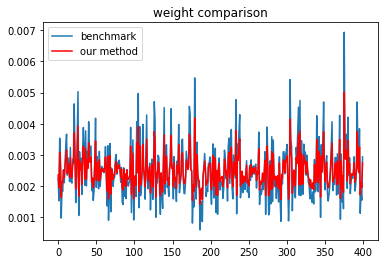

In [333]:
plt.plot(weights_bm, label="benchmark")
plt.plot(weights[1], c='red', label="our method")
plt.title("weight comparison")
plt.legend()

In [323]:
diff = np.sum(np.abs(weights_bm[:,:-1] - weights))
avg_diff = diff/(len(weights)*len(weights[0]))
print('The average difference of the weights is: ', avg_diff)

The average difference of the weights is:  0.00030114145064996385


In [324]:
bm_lower, bm_upper, bm_inf_mask, bm_weights = get_ci(M, Mhat_split, w_obs, calib, test, alpha)

100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 147314.33it/s]


In [334]:
evaluate_PI(bm_lower, bm_upper, M, test, label='benchmark')

,benchmark_Coverage,benchmark_Size
0,0.8964,0.012757


In [326]:
rbm_lower, rbm_upper, rbm_inf_mask, rbm_weights = get_ci_relaxed(M, Mhat_split, w_obs, calib, test, alpha)

100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 133822.04it/s]


In [335]:
evaluate_PI(rbm_lower, rbm_upper, M, test, label='conservative')

,conservative_Coverage,conservative_Size
0,0.902,0.013388
